In [1]:
import sqlite3
import pandas as pd 
import matplotlib.pyplot as plt 
from plot_function import *
from itertools import cycle
from pathlib import Path
from datetime import date

In [2]:
connection = sqlite3.connect('./sample_database.db')
c = connection.cursor()

In [3]:
sample = pd.read_sql_query("""SELECT tc_fit_results.*,
                                     amp_sweep_info.crit_strain_intersect,
                                     amp_sweep_info.crit_strain_10percent,
                                     sample_prep_info.solvant,
                                     sample_prep_info.microgel_type,
                                     sample_prep_info.w_percent,
                                     solvent_infos.solvent_viscosity,
                                     frq_sweep_info.G
                                FROM tc_fit_results
                                INNER JOIN amp_sweep_info ON
                                    ((tc_fit_results.sample_ID = amp_sweep_info.sample_ID) 
                                    AND (tc_fit_results.temperature = amp_sweep_info.temperature))
                                INNER JOIN frq_sweep_info ON
                                    ((tc_fit_results.sample_ID = frq_sweep_info.sample_ID) 
                                    AND (tc_fit_results.temperature = frq_sweep_info.temperature))
                                LEFT JOIN sample_prep_info ON
                                    (tc_fit_results.sample_ID = sample_prep_info.sample_ID)
                                LEFT JOIN solvent_infos ON
                                    ((sample_prep_info.solvant = solvent_infos.solvent) 
                                    AND (tc_fit_results.temperature = solvent_infos.temperature))
                           
                           """, con=connection)

In [4]:
sample.head()

,sample_ID,temperature,contrainte_seuil_TC,err_contrainte_seuil_TC,caracteristic_shear_rate_TC,err_caracterictic_shear_rate_TC,viscosity_infini_TC,err_viscosity_infini_TC,critical_strain_TC,err_critical_strain_TC,crit_strain_intersect,crit_strain_10percent,solvant,microgel_type,w_percent,solvent_viscosity,G
0,20220120006,20,10.158857,0.163084,0.632228,0.023563,1.399462e-23,0.001972,8.709438e-25,0.000123,0.792034,0.01310,pentanol,pnipam~20211203001,0.0,0.004065,171.128200
1,20210716004,20,4.217083,0.745574,0.048746,0.017946,4.599124e-01,0.008628,5.316170e-03,0.002997,0.298050,0.00668,propylenglycol,carbopol~974p,1.8,0.062650,51.177778
2,20210716005,20,6.578729,0.605298,0.085377,0.016575,4.794559e-01,0.007005,6.222224e-03,0.001871,0.404732,0.01310,propylenglycol,carbopol~974p,1.9,0.062650,74.133333
3,20210716006,20,10.037316,0.607187,0.150848,0.019601,4.929213e-01,0.007026,7.407959e-03,0.001516,0.404732,0.01310,propylenglycol,carbopol~974p,2.0,0.062650,97.611111
4,20210716008,20,83.216399,4.262560,1.089225,0.135392,6.228906e-01,0.049327,8.153056e-03,0.002077,0.305531,0.01310,propylenglycol,carbopol~974p,3.0,0.062650,555.555556


# Effect of temperature 

## on both critical strains

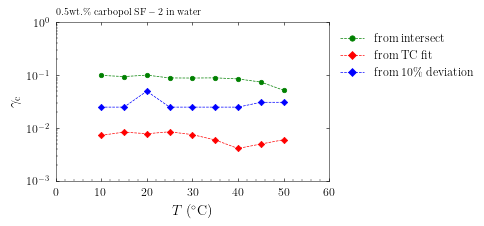

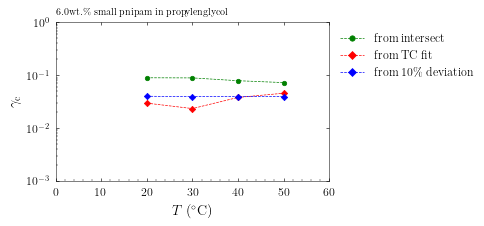

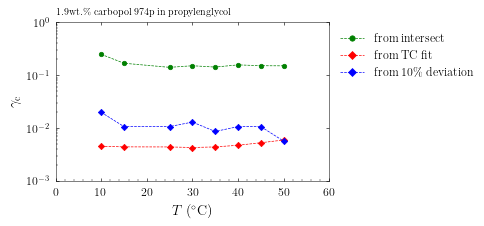

In [6]:
for sample_ID in sample.sample_ID.unique():
    unq_sample = sample[sample.sample_ID == sample_ID]
    unq_sample = unq_sample.sort_values('temperature')
    if len(unq_sample) > 3:
        fig, ax, _, _ = create_plot()
        solvent = list(unq_sample.solvant)[0]
        microgel = list(unq_sample.microgel_type)[0]
        concentration = list(unq_sample.w_percent)[0]
        ax.plot(unq_sample.temperature, unq_sample.crit_strain_intersect,
                ls='--', marker='o', c='g', mfc='g', label='$\mathrm{from~intersect}$')
        ax.plot(unq_sample.temperature, unq_sample.critical_strain_TC, ls='--', marker='D', c='r', mfc='r', label='$\mathrm{from~TC~fit}$')
        ax.plot(unq_sample.temperature, unq_sample.crit_strain_10percent, ls='--', marker='D', c='b', mfc='b', label='$\mathrm{from~10\%~deviation}$')

        ax.legend(bbox_to_anchor=(1,1))        
        ax.annotate(f'${concentration}\mathrm{{wt.}}\% \mathrm{{~{microgel}~in~{solvent}}}$', (0, 1.05), xycoords="axes fraction")  
        ax.set(yscale='log',
               xlabel=r'$T~(^\circ \mathrm{C})$',
               ylabel=r'$\gamma_\mathrm{c}$',
               xlim=(0, 60), ylim=(1e-3, 1)
                )
        #
        # fig.savefig(f'cri_strains_temperature_{solvent}_{microgel}.png', bbox_inches='tight', dpi=200)
        plt.show()
        plt.close()

## on yield stress

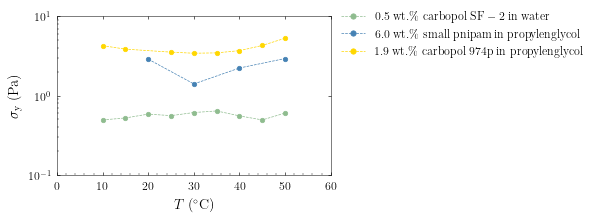

In [8]:
fig, ax, _, _ = create_plot()
color = cycle(['darkseagreen', 'steelblue', 'gold'])
for sample_ID in sample.sample_ID.unique():
    unq_sample = sample[sample.sample_ID == sample_ID]
    unq_sample = unq_sample.sort_values('temperature')
    if len(unq_sample) > 3:
        
        solvent = list(unq_sample.solvant)[0]
        microgel = list(unq_sample.microgel_type)[0]
        concentration = list(unq_sample.w_percent)[0]
        c = next(color)
        ax.plot(unq_sample.temperature, unq_sample.contrainte_seuil_TC,
                ls='--', marker='o', c=c, mfc=c, label=f'$\mathrm{{{concentration}~wt.\%~{microgel}~in~{solvent}}}$')
ax.legend(bbox_to_anchor=(1,1.1))
ax.set(yscale='log',
       xlabel=r'$T~(^\circ \mathrm{C})$',
       ylabel=r'$\sigma_\mathrm{y}~\mathrm{(Pa)}$',
       xlim=(0, 60), ylim=(1e-1, 10)
       )
#fig.savefig(f'yield_stress_temperature.png', bbox_inches='tight', dpi=200)
plt.show()
plt.close()

## on viscosities

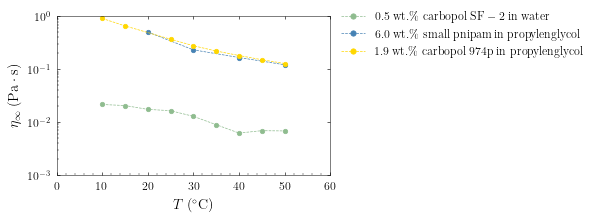

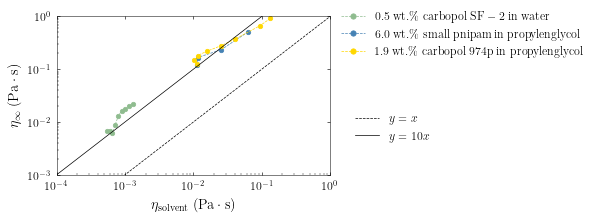

In [10]:
#----------------
# En fonction de la temperature
#----------------

fig, ax, _, _ = create_plot()
color = cycle(['darkseagreen', 'steelblue', 'gold'])
for sample_ID in sample.sample_ID.unique():
    unq_sample = sample[sample.sample_ID == sample_ID]
    unq_sample = unq_sample.sort_values('temperature')
    if len(unq_sample) > 3:
        
        solvent = list(unq_sample.solvant)[0]
        microgel = list(unq_sample.microgel_type)[0]
        concentration = list(unq_sample.w_percent)[0]
        c = next(color)
        ax.plot(unq_sample.temperature, unq_sample.viscosity_infini_TC,
                ls='--', marker='o', c=c, mfc=c, label=f'$\mathrm{{{concentration}~wt.\%~{microgel}~in~{solvent}}}$')
ax.legend(bbox_to_anchor=(1,1.1))
ax.set(yscale='log',
       xlabel=r'$T~(^\circ \mathrm{C})$',
       ylabel=r'$\eta_\infty~\mathrm{(Pa \cdot s)}$',
       xlim=(0, 60), ylim=(1e-3, 1)
       )
#fig.savefig(f'eta_infinity_temperature.png', bbox_inches='tight', dpi=200)
plt.show()
plt.close()

#----------------
# En fonction de la viscosité du solvant
#----------------

fig, ax, _, _ = create_plot()
color = cycle(['darkseagreen', 'steelblue', 'gold'])
for sample_ID in sample.sample_ID.unique():
    unq_sample = sample[sample.sample_ID == sample_ID]
    unq_sample = unq_sample.sort_values('temperature')
    if len(unq_sample) > 3:
        
        solvent = list(unq_sample.solvant)[0]
        microgel = list(unq_sample.microgel_type)[0]
        concentration = list(unq_sample.w_percent)[0]
        c = next(color)
        ax.plot(unq_sample.solvent_viscosity, unq_sample.viscosity_infini_TC,
                ls='--', marker='o', c=c, mfc=c, label=f'$\mathrm{{{concentration}~wt.\%~{microgel}~in~{solvent}}}$')
        
x=np.logspace(-4, 0, 10)
ax.plot(x, x, ls='--', c='k', marker='')
ax.plot(x, 10*x, ls='-', c='k', marker='')
handles = [mpl.lines.Line2D([], [], marker='', c='k', ls='--', label=f'$y=x$'),
           mpl.lines.Line2D([], [], marker='', c='k', ls='-', label=f'$y=10x$')]
legend = fig.legend(handles=handles, bbox_to_anchor=(1, 0.5))



ax.legend(bbox_to_anchor=(1,1.1))
ax.set(yscale='log',
       xscale='log',
       xlabel=r'$\eta_\mathrm{solvent}~(\mathrm{Pa \cdot s})$',
       ylabel=r'$\eta_\infty~\mathrm{(Pa \cdot s)}$',
       xlim=(1e-4, 1), ylim=(1e-3, 1)
       )
#fig.savefig(f'eta_infinity_eta_solvent.png', bbox_inches='tight', dpi=200)
plt.show()
plt.close()

## on caracteristic shear rates

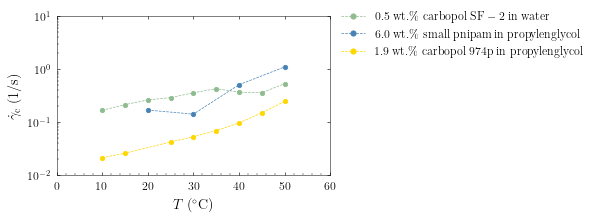

In [11]:
fig, ax, _, _ = create_plot()
color = cycle(['darkseagreen', 'steelblue', 'gold'])
for sample_ID in sample.sample_ID.unique():
    unq_sample = sample[sample.sample_ID == sample_ID]
    unq_sample = unq_sample.sort_values('temperature')
    if len(unq_sample) > 3:
        
        solvent = list(unq_sample.solvant)[0]
        microgel = list(unq_sample.microgel_type)[0]
        concentration = list(unq_sample.w_percent)[0]
        c = next(color)
        ax.plot(unq_sample.temperature, unq_sample.caracteristic_shear_rate_TC,
                ls='--', marker='o', c=c, mfc=c, label=f'$\mathrm{{{concentration}~wt.\%~{microgel}~in~{solvent}}}$')
ax.legend(bbox_to_anchor=(1,1.1))
ax.set(yscale='log',
       xlabel=r'$T~(^\circ \mathrm{C})$',
       ylabel=r'$\dot{\gamma}_\mathrm{c}~\mathrm{(1/s)}$',
       xlim=(0, 60), ylim=(1e-2, 10)
       )
#fig.savefig(f'gammadotc_temperature.png', bbox_inches='tight', dpi=200)
plt.show()
plt.close()

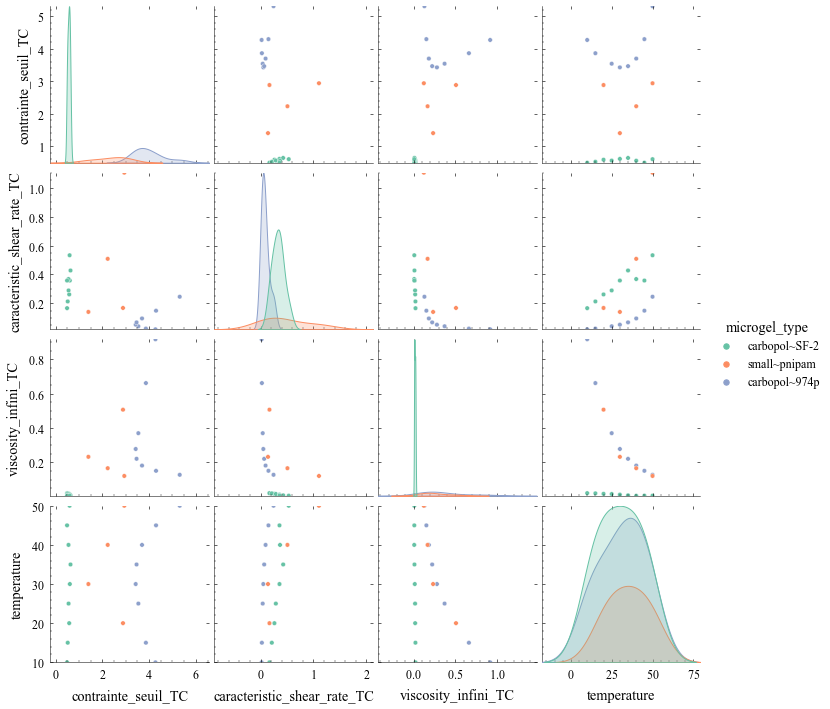

In [13]:
import seaborn as sns
from matplotlib import rc
rc('text', usetex=False)

test = sample.loc[:, ['contrainte_seuil_TC', 'caracteristic_shear_rate_TC', 'viscosity_infini_TC', 'temperature', 'microgel_type', 'sample_ID']]
for sample_ID in test.sample_ID.unique():
    if len(test[test.sample_ID == sample_ID]) <= 1:
        test = test[test.sample_ID != sample_ID]


sns.pairplot(test.loc[:, ['contrainte_seuil_TC', 'caracteristic_shear_rate_TC', 'viscosity_infini_TC', 'temperature', 'microgel_type']], hue="microgel_type", palette="Set2")
#plt.savefig('test.png', dpi=200)